In [1]:
magma_dir = '/home/marco/epfl/magma/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'led'
MODELS = {}

In [4]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_base/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/karger_books_base/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

### **Init**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [6]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')
        
    from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

    model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [7]:
def print_examples(model_name_list, df, n_examples=10):
    
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
        for model_name in model_name_list:
            model, tokenizer = import_model_tok(model_name)
            model = model.to(device)
            
            summ_enc = model.generate(
                tokenizer.encode(row.text, return_tensors='pt').to(device),
                min_length = config.ONE_BULLET_MIN_LEN,
                max_length = config.ONE_BULLET_MAX_LEN,
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]
            summ_num_tok = len(summ_enc)
            summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

            print('Prediction\n%s (%d tok):\n'%(model_name, summ_num_tok))
            print(fill(summ, 100))
            print()
            
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        print(''.join(['#']*100))
        print()

##### Plot Evaluation

In [8]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **LED on Karger Books**

In [9]:
df_train = pd.read_csv(data_dir+'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir+'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir+'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [20]:
print_examples([
    'allenai/led-base-16384'],
    df_train)

(9781910797150, 'ch04')
Prevention and management of acute and delayed CINV It is essential that oncologists and oncology
practitioners take significant time and effort to prepare patients adequately for their first course
of chemotherapy. Clinicians have a wide variety of antiemetics to choose from for the prevention of
chemotherapy-induced nausea and vomiting (CINV), and patients should receive the most effective
antiemetic agents available Outcomes are improved by following the recommendations of national or
international guidelines for CINV. Both the Multinational Association for Supportive Care in
Cancer/European Society for Medical Oncology (MASCC/ESMO) and American Society of Clinical Oncology
(ASCO) guidelines concur that the primary goal of CINV therapy is not to manage nausea and vomiting
but to prevent these symptoms from happening in the first place. - All of the guidance for managing
CINV in this book adheres to these international guidelines If antiemetic therapy is used 

Prediction
allenai/led-base-16384 (150 tok):

Prevention and management of acute and delayed CINV in patients receiving high-dose chemotherapy and
stem cell transplantation.It is essential that oncologists and oncology practitioners take
significant time and effort to prepare patients adequately for their first course of chemotherapy.
Clinicians have a wide variety of antiemetics to choose from for the prevention of chemotherapy-
induced nausea and vomiting (CINV), and patients should receive the most effective antiemetic agents
available to them.The use of antiemetic agents in the treatment of CINV is limited to patients
receiving high doses of high-dose chemotherapy or stem cell transplantation (Figure 4.6).Outcomes
are improved by following the recommendations of national or international guidelines for CIN

Reference:
The primary goal of CINV therapy is the prevention of nausea and vomiting. Patients should be
individually evaluated for their specific risk factors as well as the le

Prediction
allenai/led-base-16384 (150 tok):

clinical lesions with needles prior to excision biopsy (Figure 4.1)The use of ultrasound with
enhanced color Doppler assessment of blood flow is now the primary tool for assessment of axillary
metastases. In addition to detecting masses, it can detect increased vascularity, which can indicate
lymph-node involvement. Assessment of the axilla is now part of the standard procedure that includes
either guided cytology or core biopsy of a suspicious lymph node; if malignancy is found, sentinel
node biopsy is unnecessary and axillary clearance can be performed at the time of the first
operation (Z-11 trial). In addition, enhanced color doppler ultrasound scanning of the breast
postoperatively is likely to improve the early

Reference:
A logical process for assessing breast pain or masses will greatly enhance diagnostic accuracy.
Triple assessment - clinical examination plus imaging plus cytological or histopathological
examination - represents th

Prediction
allenai/led-base-16384 (150 tok):

, atherothrombosis. Raised antiplasmin levels do not appear to predispose to thrombosis, though low
levels occasionally lead to a bleeding state because of the unopposed action of plasminogen
activator inhibitor-2.Coagulation system is a complex of coagulation factors.The coagulation factors
are a series of plasma proteins synthesized by the liver that, when activated, generate thrombin and
convert fibrinogen to fibrin via a sequence of complex reactions. Although originally conceived as a
simple cascade, it is now viewed as an interrelated network of reactions, consisting of three
phases: initiation, propagation and termination.Initiation phase. When the endothel

Reference:
The immediate arrest of hemorrhage depends on vasoconstriction together with the adhesion and
aggregation of platelets at the site of vessel injury. The coagulation system is activated by tissue
factor expression. This binds and converts factor (F)VII to FVIIa, which i

Prediction
allenai/led-base-16384 (80 tok):

's doctor, and will decide whether they are suitable to drive on a case-by-case basis. In the USA,
people with MS may need to be assessed by a member of the Association for Driver Rehabilitation
Specialists. They will recommend no driving, adaptations to the car to assist driving or
unrestricted driving, depending on the results of a full assessment including input from the medical
team

Reference:
Counseling can be helpful for all people with multiple sclerosis (MS): it will involve explaining
the nature of the disease, the risks and benefits of therapy and the effect MS will have on all
aspects of life, including career, family, travel and insurance. Common concerns raised by patients
include life expectancy, heritability of the disease, long-term planning and effect of pregnancy.
Healthcare teams need to stress the importance of overall health and wellness in MS given the known
consequences of comorbidities in patients. A multidisciplinar

Prediction
allenai/led-base-16384 (150 tok):

Pegfilgrastim has been approved by the US FDA as a Risk Evaluation and Mitigation Strategy (REMS).
The REMS required that patients be counseled of a risk of shortened overall survival and/or
increased risk of tumor progression with ESAs before prescribing. The question of a potential
unknown 'off-target' effect of epoetins on cancer growth was raised. A potential unknown mechanism
of toxicity creates difficulties for biosimilars, as discussed in European Public Assessment Reports
(EPARs) and the US Food and Drug Administration (FDA) Oncology Drug Advisory Committee (ODAC)
briefings and discussions. Three are supportive care growth factors - epoetin alfa, filgrastim and
peg

Reference:
No biosimilar has been approved for which comparable immunogenicity in regulatory studies has not
predicted real-world outcomes in more than 10 years of European experience. For epoetin, comparable
composite outcomes were found in more than 13 000 patients tre

Prediction
allenai/led-base-16384 (150 tok):

Ethical principles and our responsibilities to protect human subjects.As more digital tools are
deployed in health research and care settings, new questions emerge about how to use them
responsibly and ethically. Anyone developing and/or testing a digital tool for use in disease
prevention and treatment within the USA should be aware of the regulatory requirement to obtain
institutional review board (IRB) approval prospectively when involving people as research
participants.The development of the IRB peer review process stemmed from egregious acts whereby
researchers disregarded the rights and welfare of research participants. One example, known as the
'Tuskegee Study of Untreated Syphilis in the Negro Male', was an observational study of the natural
progression of syphilis initiated by the Public Health Services in 1932

Reference:
The principles that guide the ethical conduct of biomedical and behavioral research include: respect
for pers

Prediction
allenai/led-base-16384 (150 tok):

X-ray exposure, but it is more expensive and more likely to provide worrisome detail rather than
useful information about the patient's condition.In general, many MRI investigations requested are
unnecessary. A simple rule for the physician is that an MRI should be carried out if malignancy is a
major concern or if surgical intervention is likely to be required. Indeed, given that discogenic
disease often settles spontaneously, it is sometimes useful to ask the patient whether their
symptoms warrant an operation. If not, a decision regarding an MRI can be postponed until the
patient is able to make an informed decision about their condition.Gadolinium-enhanced MRI utilizes
a contrast material to detect spinal tissues with increased blood flow. For example, gadolinium-

Reference:
Identifiable radiographic abnormalities such as disc degeneration, disc protrusions and osteophytes
are common in individuals over 40 years of age and almost unive

Prediction
allenai/led-base-16384 (150 tok):

al'sarcoma' elements (leiomyosarcoma, chondrosarcoma, rhabdomyosarcoma and liposarcoma). It may be
associated with past exposure to cyclophosphamide or radiation, and may be associated with
metastatic malignancies, such as bladder cancer, bladder cancer, and bladder
cancer.Lymphoepithelial-like bladder cancer accounts for 0.4-1.3% of bladder cancers.
Morphologically, it resembles nasopharyngeal lymphoepithelioma, with syncytial sheets of
undifferentiated tumor cells with minimal cytoplasm, prominent nucleoli, many mitoses and the
presence

Reference:
Urothelial carcinoma is the predominant histology of bladder cancer. Variant histology is common and
is usually seen as a mixed pattern with conventional urothelial cancer. Low-grade non-muscle-
invasive bladder tumors may recur but progression to muscle invasion occurs in < 5% of cases. High-
grade non-muscle-invasive bladder cancer will progress if not adequately treated with resection and
in

Prediction
allenai/led-base-16384 (150 tok):

Time to-event endpoints are usually expressed as a hazard ratio (HR).Many endpoints in oncology are
time-to-event endpoints, id est the time until a specified event of interest occurs, such as death
or the occurrence of disease. Typical examples are:death-overall survival (OS) and death-
progression-free survival (PFS) and death-disease-free survival (DFS) (Figure 2.1). The HR is
measured as the time until death (duration of response) of the patient.Often these endpoints are
measured from the time the participants in a study are randomized into treatment groups. This is the
case for OS, PFS and DFS, but

Reference:
Typical examples of time-to-event analyses include overall survival, progression-free survival,
disease-free survival and duration of response. Censoring is a common feature of all time-to-event
endpoints. Observations are said to be censored when the event of interest has not happened by the
end of the follow-up period. Kaplan-M

Prediction
allenai/led-base-16384 (150 tok):

8 Management of other local complications of acute or chronic pancreatitis (ACS) is not
recommended.Abdominal compartment syndrome (ACS) or acute pancreatitis (PVT) is a complication of
acute and chronic pancreatitis. The treatment of choice for pseudoaneurysms due to chronic
pancreatitis is selective angiographic embolization. Percutaneous thrombin injection has been
described as an alternative to angiography. Surgery is reserved for refractory cases of acute
pancreatitis.Peripancreatic vein thrombosis (PVT) may be associated with acute
pancreatitis.Retrospective data suggest that almost 2% of patients overall, and almost 20% of
patients with severe AP, develop

Reference:
Abdominal compartment syndrome (ACS) is defined as a sustained intra-abdominal pressure > 20 mmHg
that is associated with new organ dysfunction/failure. When non-invasive measures fail in ACS,
neuromuscular blockade with artificial respiration, percutaneous drainage or, 

##### Print Val Examples

In [21]:
print_examples([
    'allenai/led-base-16384'],
    df_val)

(9781910797471, 'ch02')
Pathophysiology and clinical stages Advances in the management of heart failure (HF) over the past
20 years have been informed by a better understanding of its pathophysiology. There are few
situations in cardiology where treatment has been as closely linked to an appreciation of the
underlying science Vicious cycle of heart failure. HF is a disease of inappropriate adaptation to
injury. The body has a limited range of compensatory responses to circulatory impairment, mainly
vasoconstriction and sodium and water retention (see below). In general, however, these adjustments
to hypovolemia are poorly suited to pump failure, and increases in the preload and afterload of the
failing heart lead to worsening HF (Figure 2.1) Neurohormonal pathways activated in HF include the
sympathetic nervous system (SNS), the renin-angiotensin-aldosterone system (RAAS) and the
natriuretic peptide (NP) system. They play a significant role in the pathophysiology of HF, and
pharmacolog

Prediction
allenai/led-base-16384 (150 tok):

Etiology and pathogenesis of eating disorders. The study of eating disorders in the United States
has found that there is a strong association between eating disorders and the development of eating
disorders.The study of eating disorders has found that eating disorders have been associated with a
complex combination of biological and environmental factors. Various genetic, developmental,
psychological, familial and social variables have been suggested as risk factors for eating
disorders.Biological factors and psychosocial factors.Biological factors. The current state of the
genetics of eating disorders is that while there is familial clustering of these syndromes, it is
not at all clear that they are in their entirety genetically transmitted disorders. Whatever the
genetic component to each one of them, it seems to be stronger

Reference:
Clinicians and patients are best served by considering eating disorders from a bio-psycho-social
persp

Prediction
allenai/led-base-16384 (150 tok):

Prostate cancer has prognostic value. The US National Cancer Institute web pages on the genetics of
prostate cancer provide a thorough review of the current status of this fast-changing field and are
updated regularly (www.cancer.gov/types/prostate/hp/prostate-genetics-pdq) and are updated
regularly.Prostate cancer is classified according to the incidence of prostate cancer. The incidence
of prostate cancer is highest in men over 50 years of age. The prevalence of prostate cancer is
higher in men under 50 years of age than in men over 60 years of age.The prevalence of prostate
cancer in men over 50 year of age is estimated to be about 1 in 8. Approximately 80% of men aged 80
years have

Reference:
Prostate cancer is soon likely to supersede lung cancer as the most common cause of cancer death in
men in western countries, as fewer men smoke and the population is aging. Age is the greatest risk
factor but race, family history, western-style d

Prediction
allenai/led-base-16384 (150 tok):

' appearance caused by the presence of phagocytic macrophages dotted about within the tumor (Figure
5.3). A characteristic feature of Burkitt lymphoma is a very high proliferation rate, usually close
to a 100%. Occasional cases of DLBLC will exhibit a similar high rate so this finding is not in
itself diagnostic. The immunophenotype is one of a mature GCB phenotype expressing CD19, CD20 and
CD10. The extreme mitotic rate is, in part, due to overexpression of the MYC oncogene, which forces
the cell to proliferate. Other terms sometimes used for particularly aggressive types of DLBCL
include'c-Myc -positive DLBCL' and '

Reference:
The commonest aggressive B-cell lymphoma is diffuse large B-cell lymphoma (DLBCL). Most DLBCL
express CD20, which is the target for rituximab; approximately 50% of DLBCL are curable with R-CHOP.
Patients who relapse require salvage chemotherapy and, if chemosensitive, will benefit from high-
dose chemotherapy and s

Prediction
allenai/led-base-16384 (150 tok):

Brain metastases are the most common intracranial tumor in the U.S. and the majority of patients
with metastatic brain metastases are at the greatest risk of developing brain
metastases.Improvements in therapy for systemic cancer have increased the number of patients living
long enough to develop symptomatic brain metastases. Indeed, brain metastases are generally
disappointing. Unfortunately, by the time most patients develop brain metastases, they have already
been exposed to the most effective chemotherapeutic agents and the metastatic clones are relatively
chemoresistant. Although the blood-brain barrier is focally disrupted, water-soluble chemotherapy
may not penetrate sufficiently to reach a therapeutic concentration. In addition, patients with
metastatic tumors are at the greatest

Reference:
Improvements in therapy for systemic cancer have resulted in an increase in the number of patients
living long enough to develop symptomatic br

Prediction
allenai/led-base-16384 (150 tok):

Management of advanced and metastatic disease is the primary endpoint. However, GC was found to be
better tolerated than MVAC and was adopted as standard of care for the treatment of metastatic
disease. Several clinical scenarios occur in bladder cancer. These include:Cancers that are clearly
confined to the bladder can potentially be cured if the primary tumor can be removed or ablated,
through surgery, radiation therapy or multimodality approaches, and there is no metastatic disease;
5-year survival rates are about 70%. Management of these cancers is discussed in chapter on
'Management of non-muscle-invasive disease' and in chapter on 'Patient management of metastatic
disease' and 'Management of metastatic disease'.Management of metastatic

Reference:
Management of patients with advanced or metastatic disease is complex and requires a
multidisciplinary approach. Management of both local and distant metastatic disease should be
considered.

Prediction
allenai/led-base-16384 (150 tok):

ology is reviewed by an expert neuropathologist and that a multidisciplinary team, including a
neuroradiologist, is involved in the diagnostic work-up. This is done by a team of
neuropathologists, including a neuropathologist and a neurosurgeon.In addition, a multidisciplinary
approach is used to determine the extent of glioblastoma. In addition, it is possible to determine
the extent and extent of glioma by using a variety of imaging techniques. For example, the following
is a list of imaging techniques used to determine glioblastomas:Diagnosis of Glioblastoma is based
on a variety of imaging methods.Diagnosis of glioma is based on

Reference:
It is important to recognize that gliomas that appear to be low-grade tumors histologically may
carry mutations associated with higher-grade tumors. The use of methylation arrays can add
diagnostic information to brain tumors that are otherwise diagnostically difficult, or where
conventional molecula

Prediction
allenai/led-base-16384 (150 tok):

ans is a very severe form of inflammatory acne associated with systemic signs and symptoms,
including fever, arthralgias and/or osteolytic lesions of the clavicles or ribs. It usually occurs
in boys aged 13-18 years and can be very acute in its onset. Investigations frequently demonstrate
leukocytosis, elevated erythrocyte sedimentation rate and/or proteinuria. Clinically, acne fulminans
is characterized by multiple intensely inflamed nodules, cysts and plaques (Figure 3.9). Large
nodules can ulcerate, drain and become necrotic. Hemorrhagic crusting is common. A polyarthritis of
large joints such as the sacroiliac

Reference:
Diagnosis is based on an accurate history, evaluation of clinical features, assessment of severity
and recognition of psychological or social issues. Further investigations are rarely required. Acne
presents with both inflammatory and comedonal lesions in most patients. Acne scarring is a very
common sequel to acne. Po

Prediction
allenai/led-base-16384 (150 tok):

Principles of management of OAPrevention versus treatment of OACurrent therapy of osteoarthritis
(OA) largely aims to treat existing disease by controlling its major symptom - pain - and maintain
or improve joint and limb function and improve quality of life. While there are numerous therapies
targeted against symptoms, at present no treatments have been definitively shown to modify the
structural progression of OA. Currently, the best advice we can give on preventing OA relates to the
following lifestyle modifications:avoid joint trauma, such as osteoporosis, and prevent
osteoporosisavoid high-impact loading of joints (through sport or occupation)avoid high-impact load
of joints (through exercise or occupation)avoid low-impact loading of the joints

Reference:
Prevention currently means advice to avoid trauma and high-impact repetitive loading of joints.
Essential management requires involving and educating the person and choosing a range 

Prediction
allenai/led-base-16384 (150 tok):

/or diplopia, occurs in approximately 15% of cases; generalized disease occurs in the remainder of
the cases.Classification by antibody status:Antibodies to AChR. As noted above, MG is most often
caused by antibodies to the AChR. This is the case for 85% of cases of generalized disease and
approximately 50% of cases of purely ocular MG. Antibodies to ACHR may be of the binding, blocking
or modulating type, with binding being the most common. AChR antibodies are highly specific for the
diagnosis of MG, although the degree of elevation in titers has never been found to correlate with
the severity of disease. Antibody titers may decline with immunos

Reference:
In myasthenia gravis (MG), pathogenic antibodies against acetylcholine receptors (AChRs) or muscle-
specific receptor tyrosine kinase (MuSK) are responsible for the abnormal neuromuscular junction
transmission leading to muscle weakness. Antibodies to AChRs reduce the number of AChRs by

##### Print Test Examples

In [22]:
print_examples([
    'allenai/led-base-16384'],
    df_test)

(9781910797105, 'ch05')
Developmental theories and environmental factors Is schizophrenia a degenerative brain disorder, as
originally thought by Kraepelin, or is it better viewed as non-progressive? During the 1990s, much
attention was given to the 'neurodevelopmental hypothesis' of schizophrenia. On the basis of the
range of observations outlined in Table 5.1, it was suggested that a static lesion, either genetic
or environmental in origin during brain development, expressed its effects as a function of the
maturational stage of the brain. In schizophrenia, the characteristic symptoms emerge only during
the final stages of brain development in adolescence, when normal 'pruning' or elimination of excess
synapses takes place. It is now known that schizophrenia results in part from a developmentally
regulated disconnection of higher order association areas, through alterations in neuronal
migration, synapse formation and myelination Neurodevelopmental risk factors Some established risk


Prediction
allenai/led-base-16384 (150 tok):

Surgery is the cornerstone of management for both early and advanced ovarian cancer, although the
aims are different in each case.The optimal timing of surgery in relation to first-line chemotherapy
is still under debate. Two prospective randomized trials, have reported lower surgical morbidity and
comparable survival when neoadjuvant therapy was given, compared with upfront surgery, but whether
these findings can be generalized to patients with good performance status treated in specialized
centers is unclear.Surgery for primary ovarian cancer is considered the cornerstone of management of
primary ovarian cancer.Surgery for secondary ovarian cancer is considered to be the cornerstone of
management.Surgical management of primary and secondary ovarian cancer may involve non-fertility-
sparing and fertility-sparing approaches (Figure 5

Reference:
Surgery is one of the cornerstones of treatment for ovarian cancer. The key aims of surgery are


Prediction
allenai/led-base-16384 (150 tok):

The role of genetics in the pathophysiology of AML is limited, as shown in Figure 1.1. The role of
genetics is limited, as described by TCGA. The role of genes is limited, as noted above and
described by TCGA, but a number of other risk factors contribute to the development of AML in some
patients. These include familial risk, environmental exposure to chemicals, drugs or ionizing
radiation, and antecedent hematologic disorders such as myelodysplastic syndromes (MDS) or
myeloproliferative neoplasms (MPN) (Figure 1.1). The role of genetics in AML is limited and
described in detail in Figure 1.2.

Reference:
Acute myeloid leukemia (AML) is a relatively rare cancer. It is due to proliferation of immature
myeloid cells, which interfere with the production of normal red blood cells, white blood cells and
platelets. Patients typically require transfusion support and are at risk for potentially fatal
infection. AML is uniformly fatal without treat

Prediction
allenai/led-base-16384 (150 tok):

stranded vector but instantly become double-stranded DNA on uncoating, resulting in improved
transduction of the T cells, resulting in improved T-cell activation, and improved T-cell
expression, resulting in reduced T-cell activation and reduced T-cell expression. The T-cell
activation of the T-cell has been shown in clinical trials. The T cell activation of the T cell has
been demonstrated in clinical trials. In clinical trials, T cell activation has been shown to
increase T cell activation, while T cell activation has shown to decrease T cell activation. T cell
activation is shown in clinical trials, but clinical trials have shown no evidence of T cell
activation in clinical trials.T cell activation has been observed in clinical trials

Reference:
Gene therapy, using gene-modified cells or in vivo gene transfer, has now been successful for
diverse diseases and modes of gene transfer. After initial setbacks, hematopoietic stem cell gene
th

Prediction
allenai/led-base-16384 (150 tok):

, as well as the effects of levodopa on Parkinson's disease. In the US, there is no evidence that
levodopa is effective in treating Parkinson's disease. However, there is evidence that it is
effective in preventing Parkinson's disease.In the UK, there is evidence of levodopa being effective
in Parkinson's disease. There is no evidence of Levodopa being effective for Parkinson's disease.
Furthermore, there is evidence for levodopa being ineffective in Parkinson's disease, but there is
no evidence of levodopamine being effective in Parkinson’s disease.There is evidence that
levodopamine is effective in Parkinson's Disease. There is evidence that levadopa is effective for
Parkinson's Disease.There

Reference:
Levodopa restores the dopamine lost due to degeneration of striatonigral cells; patients with
typical Parkinson's disease respond to levodopa almost immediately. Fear over the toxicity of
levodopa has resulted in levodopa phobia in some p

Prediction
allenai/led-base-16384 (150 tok):

Management: behavioral therapy is a fundamental pillar of CBT; in its most basic form it constitutes
a food and activity diary that records the behavior of the individual.Behavioral therapy - the
collective name for the various methods and strategies used to bring about changes in lifestyle - is
universally credited as being one of the three main pillars of weight management, alongside dietary
modification and increased physical activity (Chapters 5 and). Bringing about a change in behavior
is an important part of clinical care; the ability to foster such change in patients is fundamental
to the skill base of any health professional. Changing patients' habits and attitudes using
cognitive behavioral therapy (CBT) is key to long-term obesity management.Cognitive behavioral
therapy is an important pillar of CB

Reference:
Behavioral therapy, alongside diet and lifestyle advice, is one of the three key components of
obesity management. A perso

Prediction
allenai/led-base-16384 (150 tok):

is. Splenectomy increases susceptibility to serious bacterial infections with encapsulated
organisms, such as Streptococcus pneumoniae, Haemophilus influenzae, Neisseria meningitidis and
Capnocytophaga canimorsus. In the absence of a spleen, individuals are also at risk of severe
babesiosis and malaria. With adequate vaccinations and prophylactic antibiotics, the absolute risk
of a serious infection is very low. Nevertheless, because of these lifelong infectious risks,
surgery should be avoided altogether or preferably delayed until at least 5 years of age. If
splenectomy is needed at an earlier age, the benefits must be balanced against the risk of infection
with encapsulated organisms.Vaccination

Reference:
The burden of transfusions in pyruvate kinase (PK) deficiency is quite variable and depends on both
patient and provider factors. The decision for transfusion therapy relates to the patient's
tolerance of anemia rather than an arbitra

Prediction
allenai/led-base-16384 (150 tok):

The diagnosis of epilepsy relies on the correct classification of epileptic seizures and epilepsy
syndromes (see Chapter 2), with consequent implications for prognosis and choice of therapy for
patients with epilepsy.Video-EEG telemetry. Behavioral correlation can be achieved in inpatients by
video monitoring during the EEG. This investigation is mandatory as part of the evaluation for
epilepsy surgery, and may be the only way to distinguish epileptic from non-epileptic seizures.The
diagnostic procedure aims to answer three key questions:Is the epileptic seizure causing the
seizure?Is the seizure causing the seizure causing the epileptic seizure?Is the episode an epileptic
seizure?Does the epileptic seizure cause the seizure?What is (are) the seizure

Reference:
Epilepsy has many underlying etiologies. A wide range of conditions can mimic epileptic seizures. A
witness's account is essential for accurate diagnosis of epilepsy and classificat

Prediction
allenai/led-base-16384 (150 tok):

, the identification of gene fusions may also have a key diagnostic function for assessing risk of
malignancy, such as in thyroid nodules with undetermined cytological diagnosis. In particular, PAX8
/ PPARG and RET / CCDC6 gene fusions are more frequently associated with thyroid malignancies
(Figure 3.1).Another important field of application for RNA-based molecular approaches is the
identification of splice variants. The variation occurs at the splice site between an exon and an
intron. It leads to alternative RNA splicing, resulting from the loss of exons or the inclusion of
introns, and the generation of a novel protein (Figure 3.4) that can be used to identify the splice

Reference:
Comprehensive genomic profiles offer a complete evaluation of the genomic landscape of each tumor.
The interpretation of the different variants reported, with attention focused on their clinical
significance and usefulness for cancer patients, can support on

Prediction
allenai/led-base-16384 (47 tok):

, is important for general maintenance of health as well as bone health. Participation in organized
sports is generally possible, though the possibility of concussion should be minimized and athletes
should consider discussing their condition with team trainers and doctors in advance

Reference:
Depression and anxiety are common in patients with epilepsy, and have a significantly negative
impact on quality of life. The potential benefit of treating depression and anxiety
pharmacologically outweighs the risk of increased seizures. Psychosis is uncommon in patients with
epilepsy, and generally occurs following a cluster of complex partial seizures. When psychotropic
medications and antiepileptic drugs are coadministered, dosages may need to be adjusted because of
potential pharmacokinetic interactions. Patients should be encouraged to work whenever possible, and
to seek legal help if they encounter discrimination in the workplace. Legal restri

##### Summarize Test

In [10]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    
    model.config.max_length = 512
    model.config.min_length = 90
    
    input_ids = tokenizer(df.text.tolist(),
        return_tensors='pt',
        padding='max_length',
        max_length=8192,
        truncation=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            length_penalty = 2,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [17]:
df_test = summarize('allenai/led-base-16384', df_test, 1)

100%|██████████| 46/46 [1:18:53<00:00, 102.91s/it]


In [12]:
df_test = summarize('allenai/led-large-16384', df_test, 1)


100%|██████████| 46/46 [3:39:31<00:00, 286.33s/it]  


### **Evaluation**

In [13]:
from datasets import load_metric

metric = load_metric("rouge")

#### Evaluate summaries

In [14]:
def evaluate_model(df, model_name_or_path):
    df_eval = df.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary_'+model_name_or_path: lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df_eval

In [20]:
evaluate_model(df_test, 'allenai/led-base-16384')

,,text,bullets,summary_allenai/led-base-16384,rouge1_precision_allenai/led-base-16384,rouge1_recall_allenai/led-base-16384,rouge1_fmeasure_allenai/led-base-16384,rouge2_precision_allenai/led-base-16384,rouge2_recall_allenai/led-base-16384,rouge2_fmeasure_allenai/led-base-16384,rougeL_precision_allenai/led-base-16384,rougeL_recall_allenai/led-base-16384,rougeL_fmeasure_allenai/led-base-16384
book,chapter,,,,,,,,,,,,
9783318068207,hh-7,Non-small cell lung cancer\nLung cancer is the...,"The molecular status of, at least, EGFR, ALK, ...",. Current ESMO and ASCO guidelines do not reco...,0.289941,0.319218,0.303876,0.053412,0.058824,0.055988,0.142012,0.156352,0.148837
9781910797631,chp6,Prevention and management\nBy far the most res...,The treatment rather than the prevention of de...,Prevention and management of depression. There...,0.203540,0.534884,0.294872,0.053215,0.140351,0.077170,0.108407,0.284884,0.157051
9781910797426,ch03,Diseases of the gallbladder\nEtiology and path...,The prevalence of gallstones is greater in peo...,ubin and transaminases may be present in the g...,0.182635,0.476562,0.264069,0.066066,0.173228,0.095652,0.107784,0.281250,0.155844
9781908541277,ch_12,Quality of life\nPsychiatric comorbidities\nNe...,Depression and anxiety are common in patients ...,", is important for general maintenance of heal...",0.224242,0.496644,0.308977,0.051672,0.114865,0.071279,0.130303,0.288591,0.179541
9781910797907,chp6,"Supportive treatment\nAt present, the main foc...",The burden of transfusions in pyruvate kinase ...,is. Splenectomy increases susceptibility to se...,0.205962,0.580153,0.304000,0.040761,0.115385,0.060241,0.084011,0.236641,0.124000
9781908541277,ch_8,Antiepileptic drugs\nEstablished antiepileptic...,Sixteen new antiepileptic drugs (AEDs) have be...,Antiepileptic drugs have been shown to be effe...,0.063131,0.480769,0.111607,0.017722,0.137255,0.031390,0.055556,0.423077,0.098214
9781910797006,ch08,Acute exacerbations\nAcute exacerbations of ch...,Acute exacerbations of COPD are common and pla...,Acute exacerbations of COPD can be treated wit...,0.141414,0.629213,0.230928,0.045570,0.204545,0.074534,0.073232,0.325843,0.119588
9781910797105,ch06,Neuroanatomy and structural imaging\nOur knowl...,People with schizophrenia exhibit gray matter ...,Neuroanatomy and structural imaging. Neuropsyc...,0.173554,0.611650,0.270386,0.077348,0.274510,0.120690,0.110193,0.388350,0.171674
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,", the identification of gene fusions may also ...",0.167095,0.532787,0.254403,0.038660,0.123967,0.058939,0.089974,0.286885,0.136986


In [15]:
evaluate_model(df_test, 'allenai/led-large-16384')

,,text,bullets,summary_allenai/led-large-16384,rouge1_precision_allenai/led-large-16384,rouge1_recall_allenai/led-large-16384,rouge1_fmeasure_allenai/led-large-16384,rouge2_precision_allenai/led-large-16384,rouge2_recall_allenai/led-large-16384,rouge2_fmeasure_allenai/led-large-16384,rougeL_precision_allenai/led-large-16384,rougeL_recall_allenai/led-large-16384,rougeL_fmeasure_allenai/led-large-16384
book,chapter,,,,,,,,,,,,
9783318068207,hh-7,Non-small cell lung cancer\nLung cancer is the...,"The molecular status of, at least, EGFR, ALK, ...",asease. A high number of mutations. A mutation...,0.397260,0.094463,0.152632,0.041667,0.009804,0.015873,0.232877,0.055375,0.089474
9781910797631,chp6,Prevention and management\nBy far the most res...,The treatment rather than the prevention of de...,"--- I I I I I and I I, I I I I ( I,,,,s, I,,-,...",0.130531,0.343023,0.189103,0.028825,0.076023,0.041801,0.101770,0.267442,0.147436
9781910797426,ch03,Diseases of the gallbladder\nEtiology and path...,The prevalence of gallstones is greater in peo...,DDiagnosis and treatment. Acalculous and progn...,0.239554,0.671875,0.353183,0.097765,0.275591,0.144330,0.130919,0.367188,0.193018
9781908541277,ch_12,Quality of life\nPsychiatric comorbidities\nNe...,Depression and anxiety are common in patients ...,QualityQuality of lifeHygiene HygieneHygieneHy...,0.014286,0.006711,0.009132,0.000000,0.000000,0.000000,0.014286,0.006711,0.009132
9781910797907,chp6,"Supportive treatment\nAt present, the main foc...",The burden of transfusions in pyruvate kinase ...,"Support. In these cases, the risk of splenecto...",0.229917,0.633588,0.337398,0.072222,0.200000,0.106122,0.119114,0.328244,0.174797
9781908541277,ch_8,Antiepileptic drugs\nEstablished antiepileptic...,Sixteen new antiepileptic drugs (AEDs) have be...,DDosage. Dosing should be increased and the am...,0.063830,0.461538,0.112150,0.010667,0.078431,0.018779,0.039894,0.288462,0.070093
9781910797006,ch08,Acute exacerbations\nAcute exacerbations of ch...,Acute exacerbations of COPD are common and pla...,Ac exacerbations of COPD exacerbations in COPD...,0.134211,0.573034,0.217484,0.052770,0.227273,0.085653,0.071053,0.303371,0.115139
9781910797105,ch06,Neuroanatomy and structural imaging\nOur knowl...,People with schizophrenia exhibit gray matter ...,NeNeveNeveNevevevevevegevevevevegstststststtst...,0.164706,0.543689,0.252822,0.056047,0.186275,0.086168,0.100000,0.330097,0.153499
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,",, the number of nucleotide and the number and...",0.183463,0.581967,0.278978,0.049223,0.157025,0.074951,0.090439,0.286885,0.137525


#### Plot Evaluation

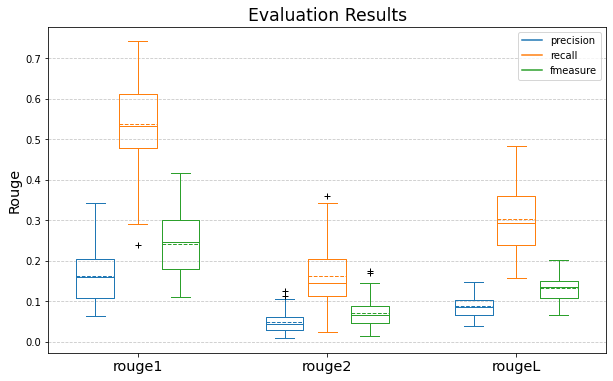

In [21]:
plot_evaluation('allenai/led-base-16384')

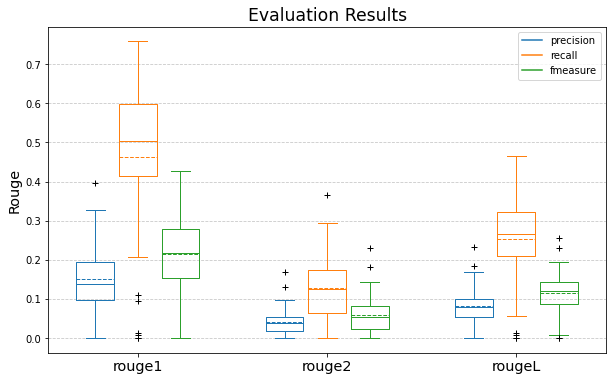

In [16]:
plot_evaluation('allenai/led-large-16384')